In [1]:
import networkx as nx

In [2]:
import torch as th

In [3]:
import networkx
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import torch.nn.functional as F
from imblearn.under_sampling import RandomUnderSampler
pd.options.mode.use_inf_as_na = True
from collections import Counter
from sklearn.feature_selection import SelectFromModel
import torch.nn as nn
import time
import pickle
from torch.nn import LayerNorm, Linear, ReLU
from torch_scatter import scatter
from tqdm import tqdm
import math
import copy
import dgl
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
import dgl
import dgl.nn as dglnn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.data.utils import *

In [5]:
import warnings
# action参数可以设置为ignore，一位一次也不喜爱你是，once表示为只显示一次
warnings.filterwarnings(action='ignore')

In [6]:
# transform = dgl.DropEdge(p=0.3)

In [7]:
class DenseGATLayer(torch.nn.Module):
    def __init__(self, conv, norm, act):
        super().__init__()
        self.conv = conv
        self.norm = norm
        self.act = act
    def forward(self, g, x):
#         graph = transform(g)
        h = self.conv(g, x)
#         h = self.norm(h)
#         h = h.view(-1, h.size(1) * h.size(2))
        h = self.act(h)
        h = torch.cat([x, h], -1)
        return h
class GAT(torch.nn.Module):
    def __init__(self, in_dim, growth_rate, out_dim, k, num_heads):
        super(GAT, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(k):
            conv = dgl.nn.GraphConv(in_dim + growth_rate * i * num_heads, growth_rate)
            norm = nn.LayerNorm(growth_rate)
            act = F.elu
            layer = DenseGATLayer(conv, norm, act)
            self.layers.append(layer)
        self.pred = nn.Linear(growth_rate * k * num_heads + in_dim, out_dim)
    def forward(self, g, h):
        for layer in self.layers:
            h = layer(g, h)
        h = h.squeeze() # 去掉所有维度为1的
        h = self.pred(h)
        return h
def accuracy(logits, labels):
    _, indices = torch.max(logits, dim=1)
    correct = torch.sum(indices == labels)
    return correct.item() * 1.0 / len(labels)


In [8]:
class DenseGATLayer2(torch.nn.Module):
    def __init__(self, conv, norm, act):
        super().__init__()
        self.conv = conv
        self.norm = norm
        self.act = act
    def forward(self, g, x):
        h = self.conv(g, x)
        h = h.view(-1, h.size(1) * h.size(2))
        h = self.act(h)
        h = torch.cat([x, h], -1)
        return h
class GAT(torch.nn.Module):
    def __init__(self, in_dim, growth_rate, out_dim, k, num_heads):
        super(GAT, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(k):
            conv = dgl.nn.GATConv(in_dim + growth_rate * i * num_heads, growth_rate, num_heads=1)
            norm = nn.LayerNorm(growth_rate)
            act = F.relu
            layer = DenseGATLayer2(conv, norm, act)
            self.layers.append(layer)
        self.pred = nn.Linear(growth_rate * k * num_heads + in_dim, out_dim)
    def forward(self, g, h):
        for layer in self.layers:
            h = layer(g, h)
        h = h.squeeze() # 去掉所有维度为1的
        h = self.pred(h)
        return h
def accuracy(logits, labels):
    _, indices = torch.max(logits, dim=1)
    correct = torch.sum(indices == labels)
    return correct.item() * 1.0 / len(labels)


In [9]:
model = GAT(in_dim=78, growth_rate=10, out_dim=15, k=5, num_heads=1)

In [10]:
# np.random.seed(2022)

In [11]:
data, _ = load_graphs("dgl_cic2017data50w.bin")

In [12]:
train_lg, test_lg = data[0], data[1]

In [13]:
train_lg = dgl.add_self_loop(train_lg)
test_lg = dgl.add_self_loop(test_lg)

In [14]:
features = train_lg.ndata['x']

In [15]:
labels = train_lg.ndata['y']

In [16]:
features.shape

torch.Size([739589, 78])

In [17]:
train_lg

Graph(num_nodes=739589, num_edges=1730800876,
      ndata_schemes={'y': Scheme(shape=(), dtype=torch.int64), 'x': Scheme(shape=(78,), dtype=torch.float32)}
      edata_schemes={})

In [19]:
Counter(train_lg.ndata['y'].numpy())

Counter({9: 161087,
         0: 350000,
         2: 111163,
         1: 89617,
         5: 5555,
         8: 3849,
         6: 4128,
         7: 4057,
         10: 7205,
         12: 1055,
         13: 456,
         3: 1369,
         4: 25,
         14: 15,
         11: 8})

In [24]:
# model = torch.load('dgldensegat_cic2017')

In [21]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)

In [23]:
all_loss = []

In [51]:
for epoch in range(100):
    logits = model(train_lg, features)
    loss = F.cross_entropy(logits, labels)
    print(loss)
    all_loss.append(loss)
    opt.zero_grad()
    loss.backward()
    opt.step()

KeyboardInterrupt: 

In [42]:
import matplotlib.pyplot as plt
plt.plot(all_loss)

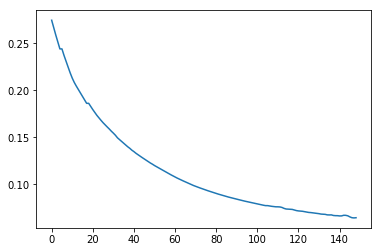

In [45]:
plt.plot(all_loss)

In [53]:
np.save( 'all_loss_cicids2017', all_loss)

In [46]:
torch.save(model, 'dgldensegat50_cic2017')

In [39]:
# torch.save(model, 'dgldensegat3_cic2017')

In [36]:
test_lg

Graph(num_nodes=316967, num_edges=314433630,
      ndata_schemes={'y': Scheme(shape=(), dtype=torch.int64), 'x': Scheme(shape=(78,), dtype=torch.float32)}
      edata_schemes={})

In [27]:
test_features = test_lg.ndata['x']

In [47]:
model.eval()
logits = model(test_lg, test_features)
_, indices = torch.max(logits, dim=1)

In [48]:
cr = confusion_matrix(test_lg.ndata['y'], indices)

In [49]:
report = classification_report(test_lg.ndata['y'], indices, digits=4)

In [50]:
print(report)

              precision    recall  f1-score   support

           0     0.9768    0.9718    0.9743    150000
           1     0.9974    0.9851    0.9912     38408
           2     0.9762    0.9928    0.9845     47641
           3     0.9928    0.2351    0.3802       587
           4     0.6667    0.3636    0.4706        11
           5     0.8845    0.8685    0.8764      2380
           6     0.9704    0.5376    0.6919      1769
           7     0.9076    0.8022    0.8516      1739
           8     0.9194    0.8715    0.8948      1650
           9     0.9599    0.9972    0.9782     69037
          10     0.9799    0.9488    0.9641      3088
          11     1.0000    0.3333    0.5000         3
          12     0.5600    0.0929    0.1594       452
          13     0.0000    0.0000    0.0000       196
          14     0.0000    0.0000    0.0000         6

    accuracy                         0.9740    316967
   macro avg     0.7861    0.6000    0.6478    316967
weighted avg     0.9730   

In [40]:
print(report)

              precision    recall  f1-score   support

           0     0.9707    0.9672    0.9690    150000
           1     0.9904    0.9979    0.9942     38408
           2     0.9718    0.9924    0.9820     47641
           3     0.9908    0.3680    0.5366       587
           4     0.7500    0.2727    0.4000        11
           5     0.9177    0.5294    0.6715      2380
           6     0.8645    0.5376    0.6629      1769
           7     0.8573    0.5285    0.6539      1739
           8     0.9079    0.8248    0.8644      1650
           9     0.9568    0.9957    0.9759     69037
          10     0.9564    0.9236    0.9397      3088
          11     0.0000    0.0000    0.0000         3
          12     0.5246    0.0708    0.1248       452
          13     0.0000    0.0000    0.0000       196
          14     0.0000    0.0000    0.0000         6

    accuracy                         0.9686    316967
   macro avg     0.7106    0.5339    0.5850    316967
weighted avg     0.9669   

In [31]:
print(report)

              precision    recall  f1-score   support

           0     0.9497    0.9397    0.9447    150000
           1     0.7791    0.9840    0.8696     38408
           2     0.9387    0.9887    0.9631     47641
           3     0.0000    0.0000    0.0000       587
           4     0.3750    0.2727    0.3158        11
           5     0.2651    0.0534    0.0888      2380
           6     0.3047    0.0661    0.1087      1769
           7     0.7485    0.5014    0.6006      1739
           8     0.7892    0.7467    0.7674      1650
           9     0.9548    0.8874    0.9199     69037
          10     0.9604    0.6525    0.7771      3088
          11     0.0000    0.0000    0.0000         3
          12     0.0000    0.0000    0.0000       452
          13     0.0000    0.0000    0.0000       196
          14     0.0000    0.0000    0.0000         6

    accuracy                         0.9196    316967
   macro avg     0.4710    0.4062    0.4237    316967
weighted avg     0.9142   

In [37]:
print(report)

              precision    recall  f1-score   support

           0     0.9073    0.9023    0.9048     30000
           1     0.9825    0.9987    0.9905     38408
           2     0.9923    0.9909    0.9916     47641
           3     0.8663    0.9489    0.9057       587
           4     0.1538    0.1818    0.1667        11
           5     0.9455    0.7000    0.8044      2380
           6     0.5923    0.5116    0.5490      1769
           7     0.9333    0.9488    0.9410      1739
           8     0.9715    0.9715    0.9715      1650
           9     0.9860    0.9978    0.9919     69037
          10     0.9251    0.9676    0.9459      3088
          11     1.0000    0.6667    0.8000         3
          12     0.4630    0.0553    0.0988       452
          13     0.7143    0.0255    0.0493       196
          14     0.0000    0.0000    0.0000         6

    accuracy                         0.9693    196967
   macro avg     0.7622    0.6578    0.6741    196967
weighted avg     0.9674   

In [80]:
print(report)

              precision    recall  f1-score   support

           0     0.7797    0.9196    0.8439     30000
           1     0.9983    0.9813    0.9898     38408
           2     0.9924    0.8731    0.9289     47641
           3     0.8628    0.9642    0.9107       587
           4     0.0000    0.0000    0.0000        11
           5     0.9630    0.9853    0.9740      2380
           6     0.5464    0.5127    0.5290      1769
           7     0.9176    0.8384    0.8762      1739
           8     0.9603    0.9388    0.9494      1650
           9     0.9859    0.9981    0.9920     69037
          10     0.9356    0.9780    0.9563      3088
          11     0.0000    0.0000    0.0000         3
          12     0.4556    0.8164    0.5848       452
          13     0.1562    0.0255    0.0439       196
          14     0.0000    0.0000    0.0000         6

    accuracy                         0.9443    196967
   macro avg     0.6369    0.6554    0.6386    196967
weighted avg     0.9502   

In [29]:
print(report)

              precision    recall  f1-score   support

           0     0.9309    0.9080    0.9193     60000
           1     0.9650    0.9901    0.9774     38408
           2     0.9546    0.9921    0.9730     47641
           3     0.9075    0.3509    0.5061       587
           4     1.0000    0.3636    0.5333        11
           5     0.6646    0.4887    0.5632      2380
           6     0.1328    0.0266    0.0443      1769
           7     0.8282    0.5296    0.6461      1739
           8     0.8866    0.8242    0.8543      1650
           9     0.9578    0.9936    0.9754     69037
          10     0.9328    0.8769    0.9040      3088
          11     0.0000    0.0000    0.0000         3
          12     0.2381    0.0111    0.0211       452
          13     0.0000    0.0000    0.0000       196
          14     0.0000    0.0000    0.0000         6

    accuracy                         0.9463    226967
   macro avg     0.6266    0.4904    0.5278    226967
weighted avg     0.9375   

In [10]:
train_lg = load_graphs("./ToN-loT/tonlot_train_lg.bin")[0][0]

In [11]:
test_lg = load_graphs("./ToN-loT/tonlot_test_lg.bin")[0][0]

In [12]:
features = copy.copy(train_lg.ndata['h'])
test_features = copy.copy(test_lg.ndata['h'])

In [13]:
# train_lg = load_graphs("./cic2017_train_data_lg.bin")[0][0]

In [14]:
# test_lg = load_graphs("./cic2017_test_data_lg.bin")[0][0]

In [15]:
# features = copy.copy(train_lg.ndata['h'])
# test_features = copy.copy(test_lg.ndata['h'])

In [16]:
train_lg

Graph(num_nodes=645460, num_edges=3215342138,
      ndata_schemes={'h': Scheme(shape=(38,), dtype=torch.float32), 'type': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})

In [17]:
test_lg

Graph(num_nodes=276626, num_edges=593853196,
      ndata_schemes={'h': Scheme(shape=(38,), dtype=torch.float32), 'type': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})

In [17]:
train_lg = dgl.add_self_loop(train_lg)
test_lg = dgl.add_self_loop(test_lg)

In [18]:
train_lg,test_lg

(Graph(num_nodes=645460, num_edges=3215342138,
       ndata_schemes={'h': Scheme(shape=(38,), dtype=torch.float32), 'type': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={}),
 Graph(num_nodes=276626, num_edges=593853196,
       ndata_schemes={'h': Scheme(shape=(38,), dtype=torch.float32), 'type': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={}))

In [15]:
class GraphSAGE(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.conv1 = dgl.nn.SAGEConv(in_features, hidden_features, aggregator_type='mean')
        self.conv2 = dgl.nn.SAGEConv(hidden_features, out_features, aggregator_type='mean')

    def forward(self, g, x):
        with g.local_scope():
            graph = g
            x = F.relu(self.conv1(graph, x))
            x = self.conv2(graph, x)
            return x

In [16]:
class GAT(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.conv1 = dgl.nn.GATConv(in_features, hidden_features, num_heads=1)
        self.conv2 = dgl.nn.GATConv(hidden_features, out_features, num_heads=1)

    def forward(self, graph, x):
        x = self.conv1(graph, x)
        x = x.view(x.size(0), x.size(1) * x.size(2))
        x = F.relu(x)
        x = self.conv2(graph, x)
        x = x.view(x.size(0), x.size(1) * x.size(2))
        return x

In [19]:
def evaluate(model, graph, features, labels):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [15]:
index = [i for i in range(train_lg.num_nodes())]

In [63]:
import random
random.shuffle(index)

In [64]:
batch_ids = index[:500]

In [65]:
batch_g = dgl.sampling.sample_neighbors(train_lg, batch_ids, -1)

In [69]:
len(batch_g.edges(order='eid')[0])

1344928

In [70]:
batch_g

Graph(num_nodes=358047, num_edges=1344928,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(20,), dtype=torch.float32)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})

In [71]:
batch_g.ndata['label'].shape

torch.Size([358047])

In [74]:
batch_g.edata['_ID'].shape

torch.Size([1344928])

In [28]:
model = GAT(in_features=78, hidden_features=30, out_features=15)

In [17]:
model = GraphSAGE(in_features=78, hidden_features=30, out_features=15)

In [20]:
model.load_state_dict(torch.load('cic2017_dgl_gat'))

<All keys matched successfully>

In [20]:
opt = torch.optim.Adam(model.parameters(),lr=0.01)

In [21]:
device = 'cpu'

In [22]:
model = model.to(device)

In [23]:
def train_on_batch(model, graph, features):
    logits = model(graph, features)
    loss = F.cross_entropy(logits, graph.ndata['label'])
    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss

In [24]:
test_lg

Graph(num_nodes=276626, num_edges=593853196,
      ndata_schemes={'h': Scheme(shape=(38,), dtype=torch.float32), 'type': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})

In [25]:
features.shape

torch.Size([645460, 38])

In [ ]:
model.train()
for epoch in range(2000):
    start_time = time.time()
    model = model.to(device)
    model.train()
    loss = train_on_batch(model, train_lg, features)
    end_time = time.time()
    acc = evaluate(model, test_lg, test_lg.ndata['h'], test_lg.ndata['label'])
    print('epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss),
          'acc_train: {:.4f}'.format(acc),
          'time: {:.4f}s'.format(end_time - start_time))

In [53]:
torch.save(model.state_dict(), 'cic2017_dgl_gat_best')

In [32]:
model.eval()
logits = model(test_lg, test_features)
_, indices = torch.max(logits, dim=1)

In [33]:
cr = confusion_matrix(test_lg.ndata['label'], indices)

In [34]:
report = classification_report(test_lg.ndata['label'], indices, digits=4)

In [35]:
print(cr)

[[8832    1   44   12    0   19   59    0   10   22    1    0    0    0
     0]
 [   0 8958    0    0    0    0    0    0    0   42    0    0    0    0
     0]
 [ 124    2 8837    0    0    8    2    2    0    6    4    0   12    3
     0]
 [  13    0    0 1161    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    1    0    1   16    0    0    0    2    0    2    0    0    0
     0]
 [   8    2   24    0    0 4693    7   23    0    3    0    0    0    0
     0]
 [  13    3    9    0    0   12 3494    0    4    3    0    0    0    0
     0]
 [   5    0   57    0    0   74    3 3158  143    2    9    0   27    0
     0]
 [  22   17    3    0    0    0    9  215 2964   18   11    0   41    0
     0]
 [   3  113    5    0    0    1    4    5    6 8742  113    0    5    3
     0]
 [   1    2   12    0    0    2    2   34    9  144 5962    0    8    0
     0]
 [   0    0    0    0    0    0    0    0    0    0    0    6    0    0
     0]
 [   2    0    4    0    0    4   24   5

In [36]:
print(report)

              precision    recall  f1-score   support

           0     0.9788    0.9813    0.9801      9000
           1     0.9843    0.9953    0.9898      9000
           2     0.9824    0.9819    0.9822      9000
           3     0.9889    0.9889    0.9889      1174
           4     1.0000    0.7273    0.8421        22
           5     0.9749    0.9859    0.9804      4760
           6     0.9695    0.9876    0.9784      3538
           7     0.9046    0.9080    0.9063      3478
           8     0.9433    0.8982    0.9202      3300
           9     0.9726    0.9713    0.9720      9000
          10     0.9712    0.9653    0.9683      6176
          11     1.0000    1.0000    1.0000         6
          12     0.6398    0.8429    0.7274       904
          13     0.5385    0.1071    0.1787       392
          14     0.0000    0.0000    0.0000        12

    accuracy                         0.9643     59762
   macro avg     0.8566    0.8227    0.8277     59762
weighted avg     0.9633   

In [64]:
print(report)

              precision    recall  f1-score   support

           0     0.9891    0.9947    0.9919      9000
           1     0.9991    0.9993    0.9992      9000
           2     0.9973    0.9957    0.9965      9000
           3     0.9882    0.9949    0.9915      1174
           4     1.0000    1.0000    1.0000        22
           5     0.9987    0.9958    0.9973      4760
           6     0.9955    0.9904    0.9929      3538
           7     0.9896    0.9848    0.9872      3478
           8     0.9869    0.9824    0.9847      3300
           9     0.9974    0.9976    0.9975      9000
          10     0.9936    0.9979    0.9957      6176
          11     1.0000    1.0000    1.0000         6
          12     0.7126    0.9325    0.8079       904
          13     0.5714    0.1633    0.2540       392
          14     0.6667    0.1667    0.2667        12

    accuracy                         0.9883     59762
   macro avg     0.9257    0.8797    0.8842     59762
weighted avg     0.9876   

In [50]:
print(report)

              precision    recall  f1-score   support

           0     0.9891    0.9947    0.9919      9000
           1     0.9991    0.9993    0.9992      9000
           2     0.9973    0.9957    0.9965      9000
           3     0.9882    0.9949    0.9915      1174
           4     1.0000    1.0000    1.0000        22
           5     0.9987    0.9958    0.9973      4760
           6     0.9955    0.9904    0.9929      3538
           7     0.9896    0.9848    0.9872      3478
           8     0.9869    0.9824    0.9847      3300
           9     0.9974    0.9974    0.9974      9000
          10     0.9934    0.9979    0.9956      6176
          11     1.0000    1.0000    1.0000         6
          12     0.7126    0.9325    0.8079       904
          13     0.5714    0.1633    0.2540       392
          14     0.6667    0.1667    0.2667        12

    accuracy                         0.9883     59762
   macro avg     0.9257    0.8797    0.8842     59762
weighted avg     0.9876   

In [30]:
print(report)

              precision    recall  f1-score   support

           0     0.9655    0.9866    0.9759      9000
           1     0.9913    0.9987    0.9950      9000
           2     0.9925    0.9724    0.9824      9000
           3     0.9838    0.9855    0.9847      1174
           4     1.0000    1.0000    1.0000        22
           5     0.9947    0.9933    0.9940      4760
           6     0.9875    0.9862    0.9868      3538
           7     0.9755    0.9718    0.9736      3478
           8     0.9771    0.9676    0.9723      3300
           9     0.9894    0.9869    0.9882      9000
          10     0.9871    0.9874    0.9872      6176
          11     1.0000    1.0000    1.0000         6
          12     0.6694    0.6427    0.6558       904
          13     0.3379    0.3750    0.3555       392
          14     0.0000    0.0000    0.0000        12

    accuracy                         0.9756     59762
   macro avg     0.8568    0.8569    0.8568     59762
weighted avg     0.9757   

In [ ]:
print(report)